## Goal
Understanding the challenges in training neural nets such as :

1. Weight Initialization
2. Adjusting Learning Rates
3. Appropriate use of Normalization
4. Picking the right Activation Functions
5. Understanding the flow of gradients through the network

## Task
Training Autoencoders (AEs) and Variational Autoencoders (VAEs) on the task of efficiently encoding and decoding (reconstructing) images (grayscale) consisting of a white square with side lengthl sampled uniformly and located at some random position in an image that is otherwise of just all black pixels.

(Task inspired from this [paper](https://arxiv.org/pdf/1606.05579) and explained in this [video](https://www.youtube.com/watch?v=9zKuYvjFFS8))

#### Objective: 
Get the autoencoder to learn latent representations that encode the location (x, y) and size of the square to enable efficient reconstruction.

In [ ]:
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

## Creating the dataset

In [380]:
# square_size -> (min_size, max_size)

def generate_datapoint(size = (28, 28), square_size = (3, 7)):
    
    assert square_size[0] < size[0] and square_size[0] < size[1]
    assert square_size[1] < size[0] and square_size[1] < size[1]
    
    img = np.zeros(size)
    
    random_square_size = random.randint(*square_size)
    
    x_pos = random.randint(0, size[1] - random_square_size)
    y_pos = random.randint(0, size[0] - random_square_size)
    
    img[x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = 1.0
    
    return img, x_pos, y_pos, random_square_size


def generate_dataset(n = 3000, size = (28, 28), square_size = (3, 7)):
    x = []
    y = []
    
    for _ in range(n):
        img, x_pos, y_pos, spot_size = generate_datapoint(size, square_size)
        x.append(img)
        y.append([x_pos, y_pos, spot_size])
        
    return np.array(x), np.array(y)

In [381]:
X, y = generate_dataset(n = 3000, size = (34, 34), square_size = (3, 7))

In [382]:
X_val, y_val = generate_dataset(n = 512, size = (34, 34), square_size = (3, 7))

In [383]:
X.shape

(3000, 34, 34)

In [384]:
X_val.shape

(512, 34, 34)

## Define Autoencoder Model

In [385]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [386]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.is_log_mode = False
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),  # Add BatchNorm2d after Conv2d
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 256),
            nn.BatchNorm1d(256),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),  # Add BatchNorm1d after Linear layer
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),

            nn.Linear(256, 16 * 16 * 16),
            nn.LeakyReLU(inplace=True),

            nn.Unflatten(1, (16, 16, 16)),  # Match the shape after last Conv2d in encoder
            
            nn.ConvTranspose2d(16, 1, 3),
            nn.Upsample(scale_factor= 34/18, mode='nearest'),
    
            nn.Sigmoid()
        )
                
    def forward(self, x):
    
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded, encoded
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def log_mode(self, val):
        assert type(val) == bool
        self.is_log_mode = val


In [387]:
ae_model = Autoencoder()

In [388]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-5)

## Train AE

In [389]:
batch_size = 32
n_train_batches = X.shape[0] // batch_size
n_val_batches = X_val.shape[0] // batch_size
n_epochs = 30
losses = []
val_losses = []

for epoch in range(n_epochs):
    
    ae_model.train()
    for batch_ind in range(n_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size]).unsqueeze(1)
        reconstructed, _ = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss.item())
    
    ae_model.eval()
    with torch.no_grad():
        val_loss = torch.Tensor([0])
        for batch_ind in range(n_val_batches):
            x = torch.Tensor(X_val[batch_ind * batch_size : (batch_ind + 1) * batch_size]).unsqueeze(1)
            reconstructed, _ = ae_model(x)
            
            val_loss += ae_criterion(reconstructed, x)
            
        
        val_loss = val_loss.item() / n_val_batches
        val_losses.append(val_loss)
        print(f"Epoch : {epoch} loss = {losses[-1]:.5f} \t val_loss = {val_loss:.5f}")

Epoch : 0 loss = 0.20974 	 val_loss = 0.21160
Epoch : 1 loss = 0.15191 	 val_loss = 0.15531
Epoch : 2 loss = 0.11157 	 val_loss = 0.11586
Epoch : 3 loss = 0.08453 	 val_loss = 0.08870
Epoch : 4 loss = 0.06651 	 val_loss = 0.07020
Epoch : 5 loss = 0.05438 	 val_loss = 0.05757
Epoch : 6 loss = 0.04605 	 val_loss = 0.04881
Epoch : 7 loss = 0.04018 	 val_loss = 0.04255
Epoch : 8 loss = 0.03591 	 val_loss = 0.03794
Epoch : 9 loss = 0.03267 	 val_loss = 0.03443
Epoch : 10 loss = 0.03012 	 val_loss = 0.03165
Epoch : 11 loss = 0.02804 	 val_loss = 0.02938
Epoch : 12 loss = 0.02627 	 val_loss = 0.02746
Epoch : 13 loss = 0.02474 	 val_loss = 0.02578
Epoch : 14 loss = 0.02338 	 val_loss = 0.02428
Epoch : 15 loss = 0.02214 	 val_loss = 0.02292
Epoch : 16 loss = 0.02100 	 val_loss = 0.02169
Epoch : 17 loss = 0.01993 	 val_loss = 0.02055
Epoch : 18 loss = 0.01895 	 val_loss = 0.01950
Epoch : 19 loss = 0.01803 	 val_loss = 0.01853
Epoch : 20 loss = 0.01719 	 val_loss = 0.01764
Epoch : 21 loss = 0.016

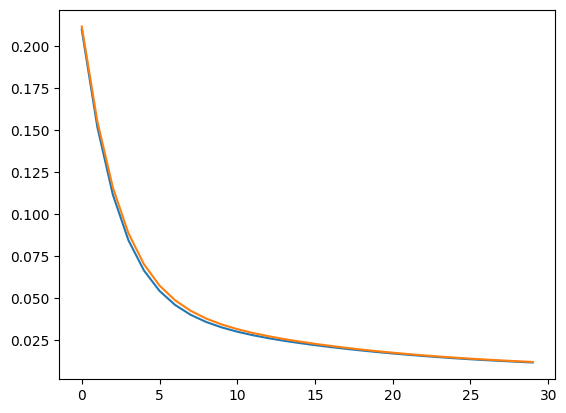

In [390]:
plt.plot(losses)
plt.plot(val_losses)

plt.show()

In [391]:
ae_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4096, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=256, out_feature

In [392]:
_x = torch.Tensor(X[20]).unsqueeze(0).unsqueeze(1)

In [393]:
_x.shape

torch.Size([1, 1, 34, 34])

In [394]:
_recon, latent = ae_model(_x)

In [395]:
ae_criterion(_recon, _x)

tensor(0.0107, grad_fn=<MseLossBackward0>)

In [396]:
img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

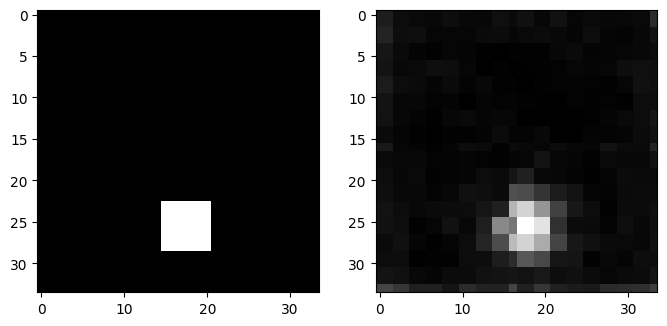

In [398]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4)
axes[0].imshow(img, cmap = 'gray')
axes[1].imshow(recon_img, cmap = 'gray')

plt.show()

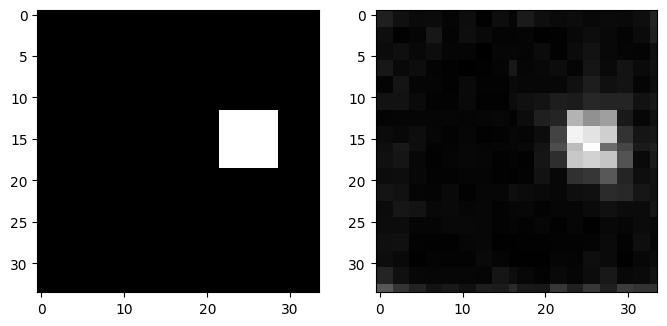

In [400]:
_x = torch.Tensor(X[25]).unsqueeze(0).unsqueeze(1)
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img, cmap = 'gray')
axes[1].imshow(recon_img, cmap = 'gray')

plt.show()

## Scratch Area

In [153]:
torch.Tensor(X[32:64]).unsqueeze(1).shape

torch.Size([32, 1, 32, 32])

In [198]:
ae_criterion(torch.Tensor(X[0:batch_size]).unsqueeze(1).flatten(), torch.Tensor(X[batch_size:batch_size*2]).unsqueeze(1).flatten())

0.0465235710144043

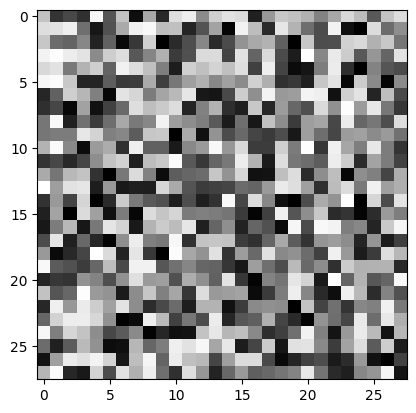

In [85]:
# x = np.ones((28, 28), dtype = np.uint8) * 255
# plt.imshow(x, cmap='gray', vmin=0, vmax=255)


x = np.ones((28, 28)) * np.random.uniform(size = (28, 28)) * 255
plt.imshow(x, cmap = 'gray')